<a href="https://colab.research.google.com/github/mar25-iia2-radiographies/01_data_exploration/blob/main/01_data_exploration_romuald.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version of the dataset
# This will download the dataset to a local path in the Colab environment.
# kagglehub handles authentication if your Kaggle API key is configured or you're logged in.
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Le dataset a été téléchargé ici :", path)


Using Colab cache for faster access to the 'covid19-radiography-database' dataset.
Le dataset a été téléchargé ici : /kaggle/input/covid19-radiography-database


Le chemin affiché ci-dessus (path) est l'emplacement où les fichiers du dataset ont été téléchargés et décompressés. Vous pouvez maintenant explorer ce répertoire pour accéder aux données.

In [2]:
# Affichons le contenu du dossier du dataset pour comprendre sa structure.
import os

dataset_path = path # 'path' est la variable contenant le chemin du dataset téléchargé.

print(f"Contenu du dossier : {dataset_path}")
for root, dirs, files in os.walk(dataset_path):
    # Limiter l'affichage pour ne pas surcharger la sortie
    indentation = '  ' * (root.count(os.sep) - dataset_path.count(os.sep))
    print(f"{indentation}├── {os.path.basename(root)}/")
    for d in dirs:
        print(f"{indentation}│   ├── {d}/")
    for f in files:
        if f.endswith(('.png', '.jpg', '.jpeg', '.gif')):
            print(f"{indentation}│   ├── {f}")
    # Limiter à 2 niveaux de profondeur pour l'affichage initial
    if root.count(os.sep) - dataset_path.count(os.sep) >= 2:
        del dirs[:] # Don't go deeper into this directory

Contenu du dossier : /kaggle/input/covid19-radiography-database
├── covid19-radiography-database/
│   ├── COVID-19_Radiography_Dataset/
  ├── COVID-19_Radiography_Dataset/
  │   ├── Normal/
  │   ├── Lung_Opacity/
  │   ├── Viral Pneumonia/
  │   ├── COVID/
    ├── Normal/
    │   ├── images/
    │   ├── masks/
    ├── Lung_Opacity/
    │   ├── images/
    │   ├── masks/
    ├── Viral Pneumonia/
    │   ├── images/
    │   ├── masks/
    ├── COVID/
    │   ├── images/
    │   ├── masks/


Après avoir exploré la structure du dataset, nous allons sélectionner un sous-dossier contenant des images (par exemple, 'COVID' ou 'NORMAL') pour afficher quelques exemples. Nous utiliserons Pillow pour charger les images et matplotlib pour les afficher.

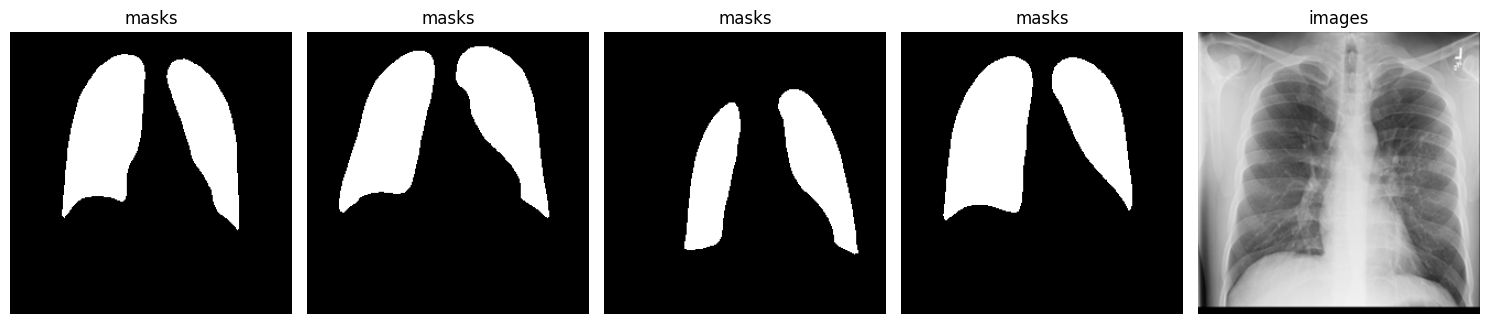

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import glob

# Ajustez ce chemin en fonction de la structure réelle du dataset que vous avez vue ci-dessus.
# Par exemple, si les images sont dans 'dataset_path/COVID/images/', vous ajusteriez ici.

# Pour cet exemple, supposons que les images sont dans un sous-dossier comme 'COVID'
# Nous allons essayer de trouver un sous-dossier d'images communes.

# On va chercher des dossiers qui semblent contenir des images (e.g., 'COVID', 'NORMAL', 'Lung_Opacity', 'Viral Pneumonia')
# On prend le premier qu'on trouve pour l'exemple.

image_subfolder = None
for root, dirs, files in os.walk(dataset_path):
    for d in dirs:
        if d in ['COVID', 'NORMAL', 'Lung_Opacity', 'Viral Pneumonia']:
            image_subfolder = os.path.join(root, d)
            break
    if image_subfolder: # Found a suitable subfolder, break outer loop
        break

if image_subfolder:
    # Liste tous les fichiers image dans le sous-dossier sélectionné
    image_files = glob.glob(os.path.join(image_subfolder, '*', '*.png')) + \
                  glob.glob(os.path.join(image_subfolder, '*', '*.jpg'))

    if not image_files:
        print(f"Aucune image trouvée dans le sous-dossier : {image_subfolder} ou ses sous-dossiers immédiats. Veuillez vérifier la structure.")
    else:
        # Sélectionner quelques images aléatoirement
        num_images_to_display = min(5, len(image_files))
        sample_images = random.sample(image_files, num_images_to_display)

        plt.figure(figsize=(15, 5))
        for i, img_path in enumerate(sample_images):
            plt.subplot(1, num_images_to_display, i + 1)
            img = Image.open(img_path)
            plt.imshow(img, cmap='gray') # Les images médicales sont souvent en niveaux de gris
            plt.title(os.path.basename(os.path.dirname(img_path))) # Affiche le nom du dossier parent (ex: COVID)
            plt.axis('off')
        plt.tight_layout()
        plt.show()
else:
    print(f"Aucun sous-dossier d'images commun (COVID, NORMAL, etc.) trouvé dans {dataset_path}. Veuillez vérifier la structure du dataset manuellement.")

# Task
Count the number of image files (png, jpg) in the 'images' subfolders for each category (COVID, Normal, Lung_Opacity, Viral Pneumonia) within the downloaded dataset and then create a bar chart visualization of these counts, showing the distribution of images across categories.

## Count Images per Category

### Subtask:
Parcourir le répertoire du dataset pour identifier les dossiers de catégories d'images (COVID, Normal, Lung_Opacity, Viral Pneumonia) et compter le nombre de fichiers image (png, jpg) dans chacun de leurs sous-dossiers 'images'.


**Reasoning**:
The subtask requires iterating through specified image categories, constructing paths to their respective 'images' subfolders, counting the number of '.png' and '.jpg' files within each, storing these counts in a dictionary, and then printing the dictionary to display the results.



In [4]:
import os
import glob

# 1. Initialize an empty dictionary to store image counts
image_counts = {}

# 2. Define a list of category names
category_names = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

# Assuming dataset_path is already defined from previous steps
# For example: dataset_path = '/kaggle/input/covid19-radiography-database'

# Construct the base directory for the categories
# Based on previous output, it's inside 'COVID-19_Radiography_Dataset'
base_category_path = os.path.join(dataset_path, 'COVID-19_Radiography_Dataset')

print(f"Counting images in: {base_category_path}")

# 3. Iterate through each category name
for category in category_names:
    # 4. Construct the full path to its 'images' subfolder
    images_folder_path = os.path.join(base_category_path, category, 'images')

    # Check if the images folder exists
    if os.path.isdir(images_folder_path):
        # 5. Use glob to find all .png and .jpg files within this subfolder
        png_files = glob.glob(os.path.join(images_folder_path, '*.png'))
        jpg_files = glob.glob(os.path.join(images_folder_path, '*.jpg'))

        # 6. Count the number of files and store in the dictionary
        total_images = len(png_files) + len(jpg_files)
        image_counts[category] = total_images
        print(f"  {category}: {total_images} images")
    else:
        print(f"  Warning: Images folder not found for category '{category}' at {images_folder_path}")
        image_counts[category] = 0 # Mark as 0 if folder not found

# 7. Print the image_counts dictionary
print("\nTotal images per category:")
for category, count in image_counts.items():
    print(f"- {category}: {count}")


Counting images in: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset
  COVID: 3616 images
  Normal: 10192 images
  Lung_Opacity: 6012 images
  Viral Pneumonia: 1345 images

Total images per category:
- COVID: 3616
- Normal: 10192
- Lung_Opacity: 6012
- Viral Pneumonia: 1345


**Reasoning**:
The previous step successfully counted the images per category. Now, as per the main task, a bar chart visualization of these counts needs to be created to show the distribution of images across categories. This requires using a plotting library, like matplotlib, to generate and display the chart.



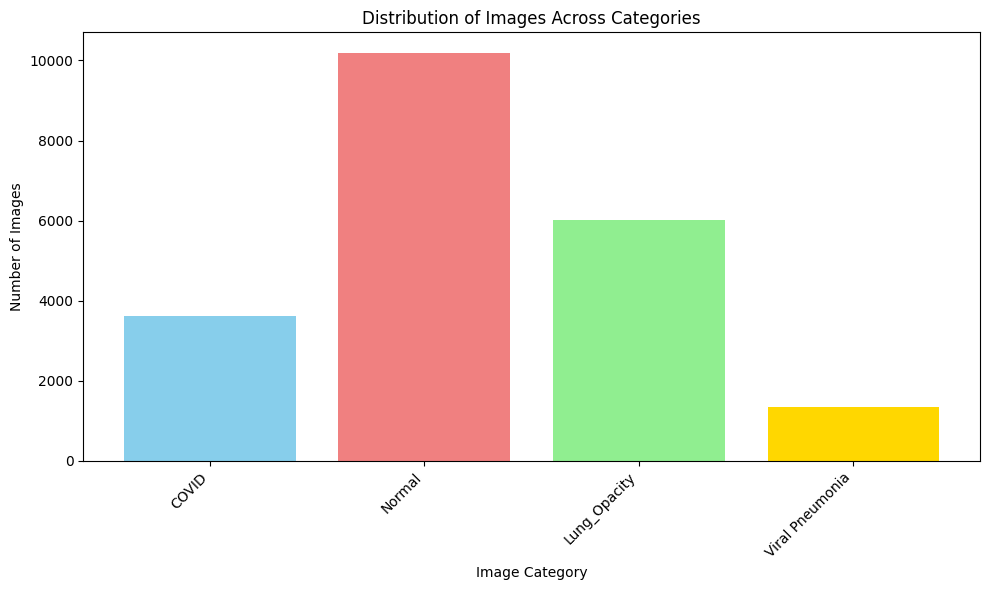

Bar chart showing image distribution created.


In [5]:
import matplotlib.pyplot as plt

# Assuming image_counts dictionary is available from the previous step
# image_counts = {'COVID': 3616, 'Normal': 10192, 'Lung_Opacity': 6012, 'Viral Pneumonia': 1345}

# Extract categories and counts for plotting
categories = list(image_counts.keys())
counts = list(image_counts.values())

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])

# Add titles and labels
plt.xlabel('Image Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Categories')
plt.xticks(rotation=45, ha='right') # Rotate category names for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping

# Display the plot
plt.show()

print("Bar chart showing image distribution created.")

# Task
The original user task is to analyze the image resolutions in the "covid19-radiography-database" dataset. This involves collecting paths to all image files (.png and .jpg) across all categories (COVID, Normal, Lung_Opacity, Viral Pneumonia), extracting the resolution (width x height) for each image, summarizing the frequency of each unique resolution, and finally presenting the most frequent resolutions along with the total number of images analyzed.

## Collect All Image Paths

### Subtask:
Parcourir le dataset pour identifier et collecter les chemins de toutes les images (fichiers .png et .jpg) dans tous les sous-dossiers de catégories (COVID, Normal, Lung_Opacity, Viral Pneumonia).


**Reasoning**:
The subtask requires iterating through predefined image categories, constructing paths to their respective 'images' subfolders, and collecting all '.png' and '.jpg' file paths into a single list.



In [6]:
import os
import glob

# 1. Initialiser une liste vide pour stocker tous les chemins d'accès aux images
all_image_paths = []

# base_category_path et category_names sont déjà définis dans les étapes précédentes
# Par exemple:
# base_category_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'
# category_names = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

print(f"Collecting image paths from categories in: {base_category_path}")

# 2. Parcourir chaque catégorie
for category in category_names:
    # 3. Construire le chemin complet vers son sous-dossier 'images'
    images_folder_path = os.path.join(base_category_path, category, 'images')

    # 4. Vérifier si ce dossier 'images' existe
    if os.path.isdir(images_folder_path):
        # 5. Utiliser glob pour trouver tous les fichiers .png et .jpg et les ajouter à la liste
        png_files = glob.glob(os.path.join(images_folder_path, '*.png'))
        jpg_files = glob.glob(os.path.join(images_folder_path, '*.jpg'))

        all_image_paths.extend(png_files)
        all_image_paths.extend(jpg_files)
        print(f"  Added {len(png_files) + len(jpg_files)} images from category '{category}'")
    else:
        print(f"  Warning: 'images' folder not found for category '{category}' at {images_folder_path}")

# 6. Afficher le nombre total de chemins d'images collectés
print(f"\nTotal number of image paths collected: {len(all_image_paths)}")

  Added 3616 images from category 'COVID'
  Added 10192 images from category 'Normal'
  Added 6012 images from category 'Lung_Opacity'
  Added 1345 images from category 'Viral Pneumonia'

Total number of image paths collected: 21165


## Extract Image Resolutions

### Subtask:
Pour chaque chemin d'image collecté, charger l'image en utilisant Pillow et extraire sa résolution (largeur x hauteur). Stocker ces résolutions dans une liste ou un dictionnaire pour le comptage.


**Reasoning**:
The subtask requires extracting the resolution of each image from the collected paths using Pillow. I will iterate through the image paths, open each image, extract its size, and store it in a list while handling potential errors.



In [7]:
from PIL import Image

# 1. Initialize an empty list to store image resolutions
image_resolutions = []

# 2. Iterate through each image path in the all_image_paths list
print(f"Extracting resolutions for {len(all_image_paths)} images...")
for i, img_path in enumerate(all_image_paths):
    if i % 1000 == 0: # Print progress periodically
        print(f"  Processing image {i}/{len(all_image_paths)}")
    try:
        # 3. Open the image using Image.open()
        with Image.open(img_path) as img:
            # 4. Extract the width and height
            width, height = img.size
            # 5. Store the resolution as a tuple (width, height)
            image_resolutions.append((width, height))
    except Exception as e:
        print(f"  Warning: Could not open or process image {img_path}: {e}")

# 6. Print the total number of resolutions extracted and a few example resolutions
print(f"\nTotal number of resolutions extracted: {len(image_resolutions)}")
if image_resolutions:
    print("Example resolutions:")
    for i, res in enumerate(image_resolutions[:5]): # Print first 5 resolutions
        print(f"- {res[0]}x{res[1]}")
else:
    print("No resolutions were extracted.")

Extracting resolutions for 21165 images...
  Processing image 0/21165
  Processing image 1000/21165
  Processing image 2000/21165
  Processing image 3000/21165
  Processing image 4000/21165
  Processing image 5000/21165
  Processing image 6000/21165
  Processing image 7000/21165
  Processing image 8000/21165
  Processing image 9000/21165
  Processing image 10000/21165
  Processing image 11000/21165
  Processing image 12000/21165
  Processing image 13000/21165
  Processing image 14000/21165
  Processing image 15000/21165
  Processing image 16000/21165
  Processing image 17000/21165
  Processing image 18000/21165
  Processing image 19000/21165
  Processing image 20000/21165
  Processing image 21000/21165

Total number of resolutions extracted: 21165
Example resolutions:
- 299x299
- 299x299
- 299x299
- 299x299
- 299x299


## Summarize and Display Resolutions

### Subtask:
Compter la fréquence de chaque résolution unique trouvée et afficher les résolutions les plus courantes ainsi que le nombre total d'images analysées.


**Reasoning**:
The subtask requires counting the frequency of each unique resolution, displaying the total number of images analyzed, and then presenting the most common resolutions. Importing `collections.Counter` will facilitate counting the frequencies, and then I will iterate through the results to display them as instructed.



In [8]:
from collections import Counter

# 1. Use Counter to count the frequency of each resolution
resolution_counts = Counter(image_resolutions)

# 2. Display the total number of images analyzed
total_images_analyzed = len(image_resolutions)
print(f"\nTotal number of images analyzed: {total_images_analyzed}")

# 3. Display the most frequent resolutions
print("\nMost frequent resolutions:")
# Get the 10 most common resolutions, or all if there are fewer than 10 unique ones
most_common_resolutions = resolution_counts.most_common(10)

for resolution, count in most_common_resolutions:
    print(f"- {resolution[0]}x{resolution[1]}: {count} occurrences")


Total number of images analyzed: 21165

Most frequent resolutions:
- 299x299: 21165 occurrences


## Visualisation des Résolutions d'Images

### Subtask:
Créer un diagramme à barres affichant la fréquence de chaque résolution d'image unique trouvée dans le dataset.

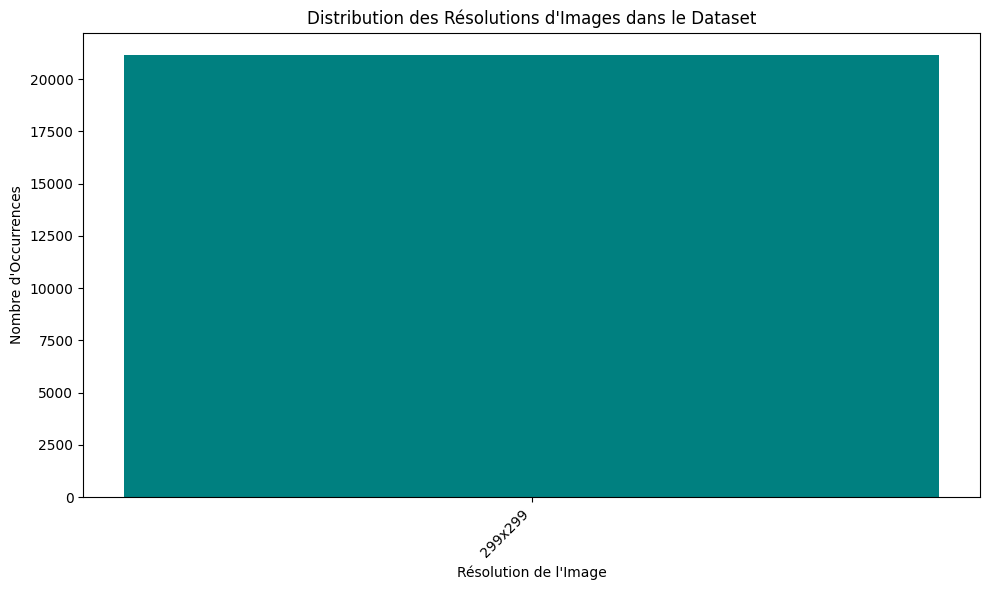

Diagramme à barres des résolutions d'images créé.

Observation: Toutes les images ont la même résolution de 299x299.


In [9]:
import matplotlib.pyplot as plt

# Assuming resolution_counts is available from the previous step
# resolution_counts = Counter({(299, 299): 21165})

# Extract resolutions and their counts for plotting
resolutions = [f"{res[0]}x{res[1]}" for res, count in resolution_counts.items()]
counts = [count for res, count in resolution_counts.items()]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(resolutions, counts, color='teal')

# Add titles and labels
plt.xlabel('Résolution de l\'Image')
plt.ylabel('Nombre d\'Occurrences')
plt.title('Distribution des Résolutions d\'Images dans le Dataset')
plt.xticks(rotation=45, ha='right') # Rotate resolution names for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping

# Display the plot
plt.show()

print("Diagramme à barres des résolutions d'images créé.")

if len(resolutions) == 1:
    print(f"\nObservation: Toutes les images ont la même résolution de {resolutions[0]}.")